# Simulate LFP from empirical spiking

This notebook explores the simulation of local field potential (LFP) recordings based on empirical spiking measurements. We perform these simulations similar to the methods in Gao - 2017, and compare them to experimental measurements of the LFP in the primary visual cortex (V1).

## Imports

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
from scipy.stats import linregress

import neo
from neurodsp.sim.transients import sim_synaptic_kernel
from neurodsp.utils import create_times
from specparam import SpectralModel
import elephant.conversion as conv
import quantities as pq

import sys
sys.path.append("../../allen_vc")
from analysis import compute_psd
from utils import knee_freq
from paths import PATH_EXTERNAL

print("Packages Imported!")

Packages Imported!


## Settings

In [2]:
# paths
PROJECT_PATH = 'D:/visual_encoding'
STIM_CODE = 'natural_movie_one_shuffled'

# spectra
FS = 1250
N_JOBS = -1
F_MIN = 2
F_MAX = 200
BANDWIDTH = 1

#specparam
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [2, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0, # (default: 0) 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2, # (default: 2.0)
    'aperiodic_mode'    :   'knee',
    'verbose'           :   False}

In [3]:
# create output filepaths

if not os.path.exists(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}"):
    os.mkdir(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}")
    os.mkdir(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/empirical_lfp")
    os.mkdir(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted")
    os.mkdir(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/empirical_lfp")
    

## Helper Functions

In [4]:

def linplot(df, x_name, y_name, color_by=None, ax=None):

    pdf = df.dropna(subset=[x_name, y_name])
    
    x = pdf[x_name]
    y = pdf[y_name]

    if color_by is not None:
        
        for subject in pdf[color_by].unique():

            ses_df = pdf[pdf[color_by] == subject]

            x_ses = ses_df[x_name]
            y_ses = ses_df[y_name]

            ax.scatter(x_ses, y_ses, alpha=0.7)
    else:

        ax.scatter(x, y, alpha=0.7)
        
    
    results = linregress(x, y)
    t_lin = np.linspace(min(x), max(x), 100)
    lin = results.slope * t_lin + results.intercept

    ax.plot(t_lin, lin, linewidth=5, color='red')

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.grid(True)

    return results


def plot_lfp(lfp, fs, title=None):

    # create time vector
    from neurodsp.utils import create_times
    time = create_times(len(lfp)/fs, fs)

    # plot
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])
    ax1.plot(time, lfp, 'k')
    ax2.plot(time[:FS], lfp[:FS], 'k')
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set(xlabel="Time (s)", ylabel="Voltage (uV)")

    if title is not None:
        fig.suptitle(title)

In [5]:
# functions for lfp simulation from empirical spiking

def sim_lfp_from_segment(segment):
    # get spike times for each cell type
    spike_times_e = segment.filter(cell_type='excitatory')
    spike_times_i = segment.filter(cell_type='inhibitory')

    # convert spike times to spike trains (bool array)
    fs = segment.filter(name='lfp')[0].sampling_rate # match lfp sampling rate
    spike_train_e = conv.BinnedSpikeTrain(spike_times_e, binsize=(1/fs)*pq.s).to_bool_array()
    spike_train_i = conv.BinnedSpikeTrain(spike_times_i, binsize=(1/fs)*pq.s).to_bool_array()

    # simulate lfp
    lfp = sim_lfp(spike_train_e, spike_train_i)

    return lfp


def sim_lfp(spike_train_e, spike_train_i):
    """
    Simulate LFP from spike trains of an excitatory and inhibitory population"""

    # set constants
    V_rest = -65
    V_rev_E = 0 
    V_rev_I = -80

    # simulte synaptic kernels
    psp_ampa = simulate_psp('ampa')
    psp_gaba = simulate_psp('gaba')
    
    # convolve
    lfp_e = np.convolve(spike_train_e, psp_ampa, 'same') * (V_rest - V_rev_E)
    lfp_i = np.convolve(spike_train_i, psp_gaba, 'same') * (V_rest - V_rev_I)
    
    # summate
    lfp = lfp_e + lfp_i
    
    return lfp


def simulate_psp(type):
    # set synaptic time constants
    if type=='ampa' or type=='excitatory':
        tau_r = 1e-4
        tau_d = 2e-3
        t_ker = 5*tau_d

    elif type=='gaba' or type=='inhibitory':
        tau_r = 5e-4
        tau_d = 1e-2
        t_ker = 5*tau_d

    else:
        raise ValueError('Invalid type. Please use either "ampa"/"excitatory" or "gaba"/"inhibitory"')

    # simulate synaptic kernels
    psp = sim_synaptic_kernel(t_ker, FS, tau_r, tau_d)

    return psp


def spectral_analysis(lfp, fs, fmin=2, fmax=200, bandwidth=1, 
                            n_jobs=-1, verbose=False, **specparam_kwargs):
    # compute spectral power
    spectra, freq = compute_psd(lfp, fs, fmin=fmin, fmax=fmax, 
                                bandwidth=bandwidth, n_jobs=n_jobs, 
                                verbose=verbose)

    # compute specparam metrics
    sm = SpectralModel(**specparam_kwargs)
    sm.fit(freq, spectra)

    return sm

In [126]:
# functions for conducting permutation test

def sim_lfp_perm(segments, N):
    """
    Perform a permutation test that shuffles the cell-type identification labeling
    of units. Computes the correlation of resulting simulated lfp with empirical.
    """
    
    # concatenate segment lfp and spikes
    lfps = []
    spikes = []
    for seg in segments:

        spike_times_e = seg.filter(cell_type='excitatory')
        spike_times_i = seg.filter(cell_type='inhibitory')

        fs = seg.filter(name='lfp')[0].sampling_rate
        spike_train_e = conv.BinnedSpikeTrain(spike_times_e, binsize=(1/fs)).to_bool_array()
        spike_train_i = conv.BinnedSpikeTrain(spike_times_i, binsize=(1/fs)).to_bool_array()
        
        lfp = seg.filter(name='lfp')[0].magnitude[:37500]

        if spike_train_e.shape[1] != lfp.shape[0]:
            print("LFP / spike shape mismatch")
            continue
        
        spikes.append(np.append(spike_train_e, spike_train_i, axis=0))
        lfps.append(lfp)
    
    print(lfps)
    lfp_concat = np.concatenate(lfps, axis=0)
    spikes_concat = np.concatenate(spikes, axis=1)
    
    # perform permutations
    n_e = len(segments[0].filter(cell_type='excitatory'))
    
    null_corrs = []
    for _ in range(N):
        
        # shuffle spikes
        shuffled_spikes = np.random.permutation(spikes_concat)

        # sim lfp
        spikes_e = shuffled_spikes[:n_e].sum(axis=0)
        spikes_i = shuffled_spikes[n_e:].sum(axis=0)
        
        # compute/append correlation
        simulated_lfp = sim_lfp(spikes_e, spikes_i)
        null_corrs.append(pearson_corr(simulated_lfp, lfp_concat))
        
    return np.array(null_corrs).T
        
    
def compute_pvals(null_dists, ts):
    """
    Compute the p value of a hypothesis test based on a discrete
    null distribution and test statistic.
    """
    
    if null_dists.shape[0] != len(ts) or ts.ndim != 1:
        raise ValueError("Input array dimensions don't match.")
    
    pvals = []
    for i in range(len(ts)):
        pvals.append(np.sum(null_dists[i] > ts[i])/null_dists.shape[1])
    
    return pvals


def pearson_corr(x, y):
    """
    Compute pearson correlation between two arrays along axis 0
    """
    
    x_z = x - x.mean(axis=0) / x.std(axis=0) 
    y_z = y - y.mean(axis=0) / y.std(axis=0) 
    
    corr = np.dot(x_z, y_z) / len(x_z)
    
    return corr

## Load Data

In [7]:
# load actual params
param_df = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/{STIM_CODE}/lfp_params.csv')

# change knee value to Hz
param_df['knee'] = knee_freq(param_df['knee'], param_df['exponent'])

../../allen_vc\utils.py:194: RuntimeWarning: invalid value encountered in double_scalars
  knee_hz[ii] = knee[ii]**(1/exponent[ii])


In [8]:
# interesting nan values
n_nan = (param_df['knee']**(1/param_df['exponent'])).isna().sum()
print(f"n_nan: {n_nan} ({100*n_nan/len(param_df):0.1f}%)")

n_nan: 1668 (15.4%)


## Main

### Simulate LFPs from empirical spiking

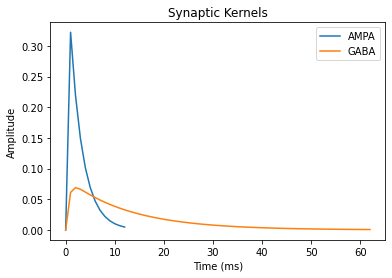

In [9]:
# create synaptic kernels based on Gao 2017

# simulate synaptic kernels
ampa = simulate_psp("excitatory")
gaba = simulate_psp("inhibitory")

# plot 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ampa, label='AMPA')
ax.plot(gaba, label='GABA')
ax.set(xlabel='Time (ms)', ylabel='Amplitude')
ax.set_title('Synaptic Kernels')
ax.legend()
plt.show()

In [10]:
# # load blocks

# sim_lfp_data = []

# for i_file, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    
#     block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
#     session = file.split('_')[1].split('.')[0]
    
#     print(f"Compute Session {session}:")
    
#     block_data = []
#     sim_lfps = []
    
#     # loop through epochs
#     for i_seg, seg in enumerate(block.segments):
        
#         if i_seg%10 == 0:
#             print(f"\t segment ({i_seg + 1}/{len(block.segments)})")
            
#         if seg.annotations['running'] is True:
#             continue
        
#         # filter spikes by cell type, convert to bool array
#         inhib = seg.filter(cell_type='inhibitory')
#         excit = seg.filter(cell_type='excitatory')
        
        
#         if len(inhib) > 0:
#             inhib_bool = conv.BinnedSpikeTrain(inhib, binsize=(1/FS)*pq.s).to_bool_array()
#             inhib_spikes = np.sum(inhib_bool, axis=0)
            
#         else:
#             inhib_spikes = np.zeros(30*FS)
            
            
#         if len(excit) > 0:
#             excit_bool = conv.BinnedSpikeTrain(excit, binsize=(1/FS)*pq.s).to_bool_array()
#             excit_spikes = np.sum(excit_bool, axis=0)
            
#         else:
#             excit_spikes = np.zeros(30*FS)
            
        
#         # convolve
#         inhib_lfp = np.convolve(inhib_spikes, gaba, 'same') # use same to preserve dimensions with lfp
#         excit_lfp = np.convolve(excit_spikes, ampa, 'same')
        
#         # summate
#         sim_lfp = excit_lfp - inhib_lfp
        
#         # compute correlation with actual lfp
#         lfp = np.array(seg.filter(name='lfp')[0])[:37500] # compute for each channel
#         # lfp[np.isnan(lfp)] = 0
        
#         if np.isnan(lfp).sum() > 0:
#             print(f"NaNs in seg {i_seg}")
            
#         if lfp.shape[0] != sim_lfp.shape[0]:
#             print(f"LFP / spike shape mismatch in seg {i_seg}")
#             continue
        
#         corrs = []
#         for i_chan in range(lfp.shape[1]):
            
#             corr = np.corrcoef(sim_lfp, lfp[:, i_chan])[0, 1] # nan values in lfp -> nan
#             corrs.append(corr)
        
#         # compute spectral power
#         spectra, freq = compute_psd(sim_lfp, FS, fmin=F_MIN, fmax=F_MAX, bandwidth=BANDWIDTH,
#                                     n_jobs=N_JOBS, verbose=False)
        
#         # compute specparam metrics
#         fm = SpectralModel(**SPEC_PARAM_SETTINGS)
#         fm.fit(freq, spectra)
#         params = fm.aperiodic_params_
        
#         block_data.append([params[0], knee_freq(params[1], params[2]), params[2], fm.r_squared_, corrs, i_seg, range(lfp.shape[1])])
#         sim_lfps.append(sim_lfp)
        
#     if len(block_data) == 0:
#         print(f"No stationary data for session {session}")
#         continue
    
#     # create dataframe
#     df = pd.DataFrame(block_data, columns=['offset', 'knee', 'exponent', 'r_squared', 'sim_corr', 'epoch_idx', 'chan_idx'])
#     df['session'] = session
#     sim_lfp_data.append(df.explode(['sim_corr', 'chan_idx']))
    
#     np.save(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/empirical_lfp/{session}", np.stack(sim_lfps))
    
# # concatenate
# sim_lfp_df = pd.concat(sim_lfp_data)

# # save
# sim_lfp_df.to_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/params.csv',index=False)

Now lets weight the convolution product by characteristic voltage potential differences for each cell type.

Reference : [rdgao](https://github.com/rdgao/specparam-sbi/blob/main/demo_notebooks/2-EI.ipynb)

In [11]:
# cell voltage potential values

# V_rest = -65
# V_rev_E = 0
# V_rev_I = -80

In [12]:
# # load blocks

# sim_lfp_data = []

# for i_file, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    
#     block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
#     session = file.split('_')[1].split('.')[0]
    
#     print(f"Compute Session {session}:")
    
#     block_data = []
#     sim_lfps = []
    
#     # loop through epochs
#     for i_seg, seg in enumerate(block.segments):
        
#         if i_seg%10 == 0:
#             print(f"\t segment ({i_seg + 1}/{len(block.segments)})")
            
#         if seg.annotations['running'] is True:
#             continue
        
#         # filter spikes by cell type, convert to bool array
#         inhib = seg.filter(cell_type='inhibitory')
#         excit = seg.filter(cell_type='excitatory')
        
        
#         if len(inhib) > 0:
#             inhib_bool = conv.BinnedSpikeTrain(inhib, binsize=(1/FS)*pq.s).to_bool_array()
#             inhib_spikes = np.sum(inhib_bool, axis=0)
            
#         else:
#             inhib_spikes = np.zeros(30*FS)
            
            
#         if len(excit) > 0:
#             excit_bool = conv.BinnedSpikeTrain(excit, binsize=(1/FS)*pq.s).to_bool_array()
#             excit_spikes = np.sum(excit_bool, axis=0)
            
#         else:
#             excit_spikes = np.zeros(30*FS)
            
        
#         # convolve
#         inhib_lfp = np.convolve(inhib_spikes, gaba, 'same') * (V_rest - V_rev_I)
#         excit_lfp = np.convolve(excit_spikes, ampa, 'same') * (V_rest - V_rev_E)
        
#         # summate
#         sim_lfp = excit_lfp + inhib_lfp
        
#         # compute correlation with actual lfp
#         lfp = np.array(seg.filter(name='lfp')[0])[:37500] # compute for each channel
#         # lfp[np.isnan(lfp)] = 0
        
#         if np.isnan(lfp).sum() > 0:
#             print(f"NaNs in seg {i_seg}")
            
#         if lfp.shape[0] != sim_lfp.shape[0]:
#             print(f"LFP / spike shape mismatch in seg {i_seg}")
#             continue
        
#         corrs = []
#         for i_chan in range(lfp.shape[1]):
            
#             corr = np.corrcoef(sim_lfp, lfp[:, i_chan])[0, 1] # nan values in lfp -> nan
#             corrs.append(corr)
        
#         # compute spectral power
#         spectra, freq = compute_psd(sim_lfp, FS, fmin=F_MIN, fmax=F_MAX, bandwidth=BANDWIDTH,
#                                     n_jobs=N_JOBS, verbose=False)
        
#         # compute specparam metrics
#         fm = SpectralModel(**SPEC_PARAM_SETTINGS)
#         fm.fit(freq, spectra)
#         params = fm.aperiodic_params_
        
#         block_data.append([params[0], knee_freq(params[1], params[2]), params[2], fm.r_squared_, corrs, i_seg, range(lfp.shape[1])])
#         sim_lfps.append(sim_lfp)
        
#     if len(block_data) == 0:
#         print(f"No stationary data for session {session}")
#         continue
        
#     # create dataframe
#     df = pd.DataFrame(block_data, columns=['offset', 'knee', 'exponent', 'r_squared', 'sim_corr', 'epoch_idx', 'chan_idx'])
#     df['session'] = session
#     sim_lfp_data.append(df.explode(['sim_corr', 'chan_idx']))
    
#     np.save(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/empirical_lfp/{session}", np.stack(sim_lfps))
    
# # concatenate
# sim_lfp_df = pd.concat(sim_lfp_data)

# # save
# sim_lfp_df.to_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/params.csv',index=False)

In [ ]:
# simulate lfp from empirical spiking across all sessions
# using modular functions


sim_lfp_data = []

# loop through sessions
for i_file, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    # load block i.e. data for a given session
    block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    session = file.split('_')[1].split('.')[0]
    
    print(f"Compute Session {session}:")
    
    # initialize data storage for session
    block_data = []
    sim_lfps = []
    
    # loop through each epoch in the block
    for i_seg, seg in enumerate(block.segments):
        # display progress
        if i_seg%10 == 0:
            print(f"\t segment ({i_seg + 1}/{len(block.segments)})")
            
        # skip running epochs (stationary data only)
        if seg.annotations['running'] is True:
            continue
        
        # simualte lfp from empirical spiking
        sim_lfp = sim_lfp_from_segment(seg)
        
        # get empirical lfp
        lfp = np.array(seg.filter(name='lfp')[0])[:37500] # compute for each channel
        # lfp[np.isnan(lfp)] = 0
        
        if np.isnan(lfp).sum() > 0:
            print(f"NaNs in seg {i_seg}")
            
        if lfp.shape[0] != sim_lfp.shape[0]:
            print(f"LFP / spike shape mismatch in seg {i_seg}")
            continue
        
        # compute correlation between simulated and empirical lfp
        corrs = []
        for i_chan in range(lfp.shape[1]):
            
            corr = np.corrcoef(sim_lfp, lfp[:, i_chan])[0, 1] # nan values in lfp -> nan
            corrs.append(corr)
        
        # compute spectral parameters
        sm = spectral_analysis(sim_lfp, FS, fmin=F_MIN, fmax=F_MAX, 
                               bandwidth=BANDWIDTH, n_jobs=N_JOBS, 
                               verbose=False, **SPEC_PARAM_SETTINGS)
        params = fm.aperiodic_params_
        
        # store data (including channel-wise correlations and spectral parameters)
        block_data.append([params[0], knee_freq(params[1], params[2]), params[2], sm.r_squared_, corrs, i_seg, range(lfp.shape[1])])
        sim_lfps.append(sim_lfp)
        
    if len(block_data) == 0:
        print(f"No stationary data for session {session}")
        continue
        
    # create dataframe for session results and append to list
    df = pd.DataFrame(block_data, columns=['offset', 'knee', 'exponent', 'r_squared', 'sim_corr', 'epoch_idx', 'chan_idx'])
    df['session'] = session
    sim_lfp_data.append(df.explode(['sim_corr', 'chan_idx']))
    
    # save simulated lfps for session to file
    np.save(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/empirical_lfp/{session}", np.stack(sim_lfps))
    
# concatenate
sim_lfp_df = pd.concat(sim_lfp_data)

# save
sim_lfp_df.to_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/params.csv',index=False)

Permutation testing

In [ ]:
# total runtime (~ 2 hours)

N = 10 # number of permutations to compute (~ 0.4 s average runtime per permutation)

# loop through sessions
p_vals = []
for i_file, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    # load block i.e. data for a given session
    block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    session = file.split('_')[1].split('.')[0]
    
    print(f"Compute Session {session}:")
    
    null_corrs = sim_lfp_perm(block.segments, 50)
    
    ps = compute_pvals(null_corrs, np.random.rand(null_corrs.shape[0]))
    p_vals.append(ps)
    

## Results

Below are results from the original methodology where the convolved current is not weighted, the simulated lfp is calculated as the excitatory minus the inhibitory current, and nans are not handled.

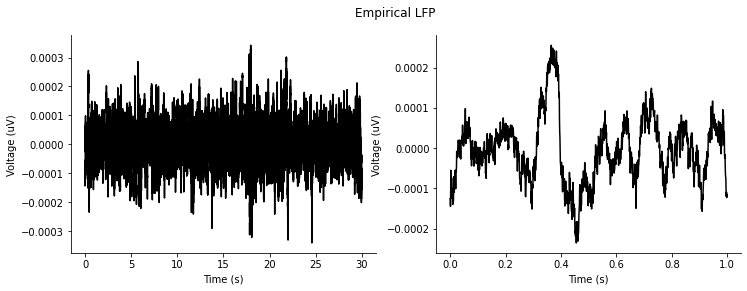

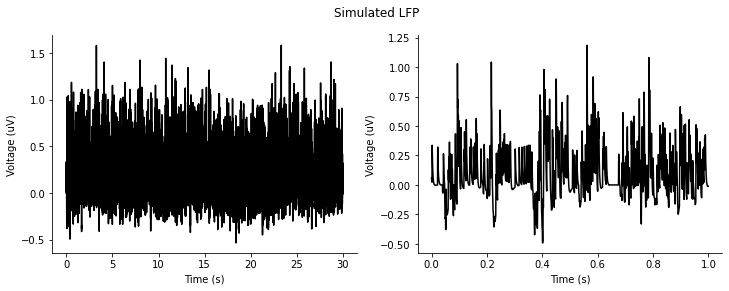

In [19]:
# load example block
session = 816200189
i_seg = 4
lfp_chan = 0

block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/block_{session}.mat").read_block()
seg = block.segments[i_seg]

lfp = np.array(seg.filter(name='lfp')[0])[:37500][:, lfp_chan]
sim_lfp = np.load(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/empirical_lfp/{session}.npy")[i_seg]

# plot empirical and simulates lfp
for signal, title in zip([lfp, sim_lfp], ['Empirical LFP', 'Simulated LFP']):
    plot_lfp(signal, FS, title)


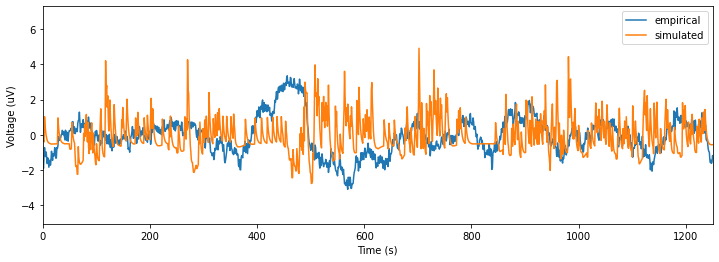

In [21]:
# plot examples with actual LFP side by side
fig, ax = plt.subplots(1, 1, figsize=[12, 4])
ax.plot(zscore(lfp), label='empirical')
ax.plot(zscore(sim_lfp), label='simulated')
ax.set_xlim([0, FS])
ax.set(xlabel="Time (s)", ylabel="Voltage (uV)")
ax.legend()
plt.show()

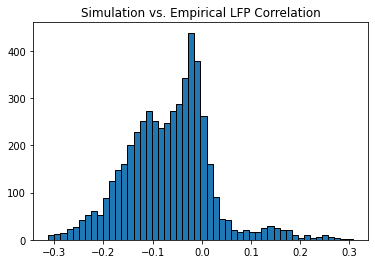

In [23]:
# plot correlation coefficient distribution
sim_lfp_df = pd.read_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/params.csv')

plt.hist(sim_lfp_df['sim_corr'], edgecolor='black', bins=50)
plt.title('Simulation vs. Empirical LFP Correlation');

<AxesSubplot:ylabel='Frequency'>

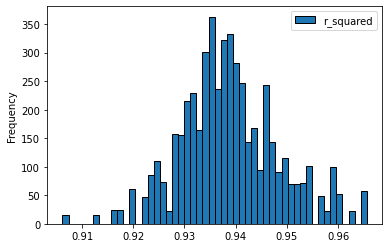

In [50]:
# plot r_squared distribution for parameterization of the simulated LFP
sim_lfp_df.plot.hist(y='r_squared', bins=50, edgecolor='black')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 19], dtype=int64)

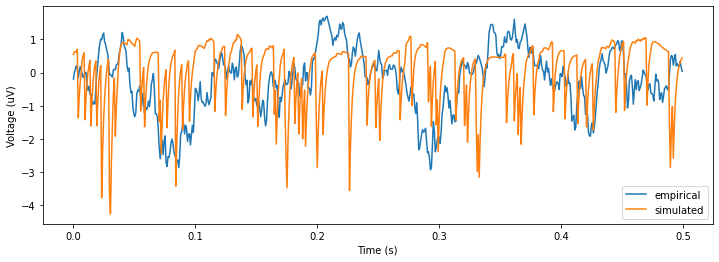

In [148]:
# plot an example of a high correlation example

# find a high-correlation example
df = sim_lfp_df.groupby(['session', 'chan_idx']).mean().reset_index()
df = df.sort_values('sim_corr', ascending=False).reset_index()

# load empirical lfp
path_in = f"{PATH_EXTERNAL}/data/blocks/segmented/by_cell_type/{STIM_CODE}"
fname = f"block_{df.loc[0, 'session']}.mat"
block = neo.io.NeoMatlabIO(f"{path_in}/{fname}").read_block()
epochs = sim_lfp_df.loc[sim_lfp_df['session'] == session, 'epoch_idx'].unique()
segment = block.segments[int(epochs[0])] # just take the first epoch
lfp_emp = np.array(segment.filter(name='lfp')[0])[:37500][:, df.loc[0, 'chan_idx']]

# load simulated lfp
path_in = f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/empirical_lfp"
data_in = np.load(f"{path_in}/{df.loc[0, 'session']}.npy")
lfp_sim = data_in[0] # just take the first epoch

# plot
time = create_times(len(lfp_emp)/FS, FS)
n_samples = int(FS/2) # plot a snippet only
fig, ax = plt.subplots(1, 1, figsize=[12, 4])
ax.plot(time[:n_samples], zscore(lfp_emp)[:n_samples], label='empirical')
ax.plot(time[:n_samples], zscore(lfp_sim)[:n_samples], label='simulated')
ax.set(xlabel="Time (s)", ylabel="Voltage (uV)")
ax.legend()
plt.show()

offset: LinregressResult(slope=-0.016906155348255517, intercept=-4.798085932563043, rvalue=-0.0069319058983369685, pvalue=0.6207239400036286, stderr=0.03416386937920177, intercept_stderr=0.07083750254220825)
knee: LinregressResult(slope=-0.02681905538615396, intercept=6.151000060071917, rvalue=-0.10810654387577995, pvalue=5.468796819984689e-12, stderr=0.0038791858574908386, intercept_stderr=0.15123541114593758)
exponent: LinregressResult(slope=-0.06147246650220931, intercept=1.996059411687623, rvalue=-0.02620783151991051, pvalue=0.061329973863851625, stderr=0.03284623851434275, intercept_stderr=0.04785054244765155)


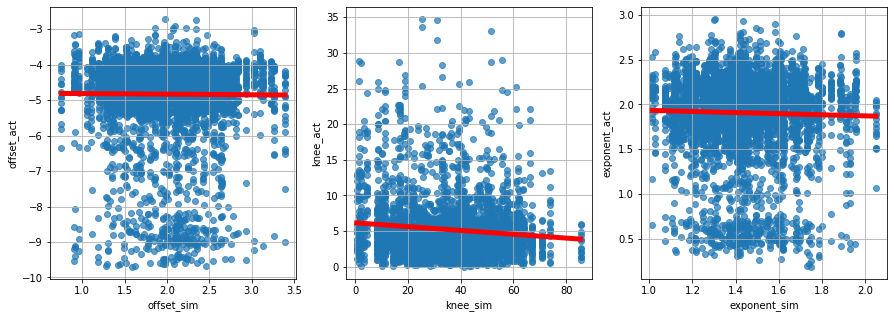

In [24]:
# plot specparams

full_df = sim_lfp_df.merge(param_df, on=['session', 'epoch_idx', 'chan_idx'], suffixes=('_sim', '_act'))

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(full_df, f"{var}_sim", f"{var}_act", ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=-0.016906155348255517, intercept=-4.798085932563043, rvalue=-0.0069319058983369685, pvalue=0.6207239400036286, stderr=0.03416386937920177, intercept_stderr=0.07083750254220825)
knee: LinregressResult(slope=-0.02681905538615396, intercept=6.151000060071917, rvalue=-0.10810654387577995, pvalue=5.468796819984689e-12, stderr=0.0038791858574908386, intercept_stderr=0.15123541114593758)
exponent: LinregressResult(slope=-0.06147246650220931, intercept=1.996059411687623, rvalue=-0.02620783151991051, pvalue=0.061329973863851625, stderr=0.03284623851434275, intercept_stderr=0.04785054244765155)


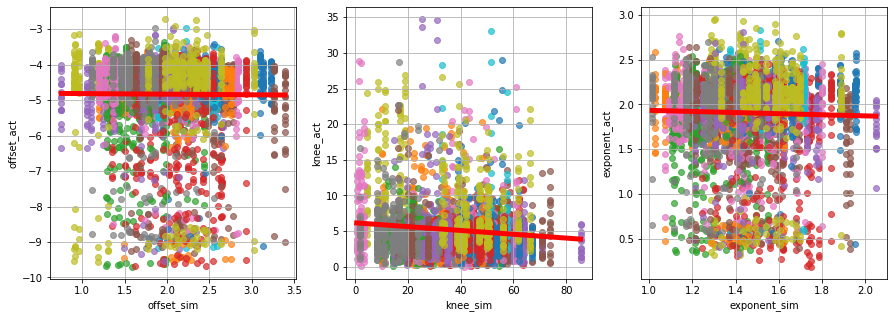

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(full_df, f"{var}_sim", f"{var}_act", color_by="session" ,ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=0.10766332510206672, intercept=-4.429621998453332, rvalue=0.35948862845559537, pvalue=0.20680400847040728, stderr=0.08067578879335714, intercept_stderr=0.1873525036399843)
knee: LinregressResult(slope=0.019270874590790132, intercept=5.302234454683097, rvalue=0.26393008457946127, pvalue=0.36188356247389164, stderr=0.020330261490842872, intercept_stderr=0.911049709200954)
exponent: LinregressResult(slope=0.099769811333663, intercept=2.293235209357073, rvalue=0.28024188689456625, pvalue=0.33182562177297814, stderr=0.0986540184825105, intercept_stderr=0.1540365841776654)


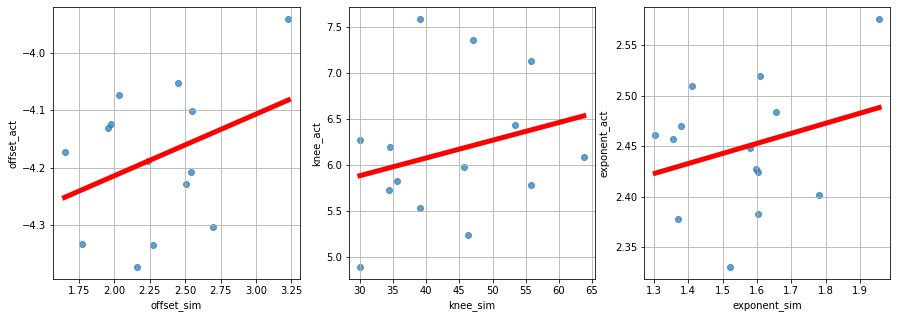

In [119]:
# plot an example for a single channel
sessions = full_df['session'].unique()
df_ex = full_df[(full_df['session']==sessions[0]) & (full_df['chan_idx']==0)]

# plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for i, var in enumerate(['offset', 'knee', 'exponent']):
    res = linplot(df_ex, f"{var}_sim", f"{var}_act", color_by="session", ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=-0.014885625031195351, intercept=-4.791956876167714, rvalue=-0.025340816739961185, pvalue=0.7111359784841058, stderr=0.04014210038466486, intercept_stderr=0.08315766345341981)
knee: LinregressResult(slope=-0.022777210400252847, intercept=5.831621122969434, rvalue=-0.20219235394099339, pvalue=0.002833369488147367, stderr=0.007541626086680704, intercept_stderr=0.2971572987874684)
exponent: LinregressResult(slope=-0.06170590731231048, intercept=2.0010603482576435, rvalue=-0.07033074803682031, pvalue=0.30351556238460714, stderr=0.05982708649819154, intercept_stderr=0.0872893872380157)


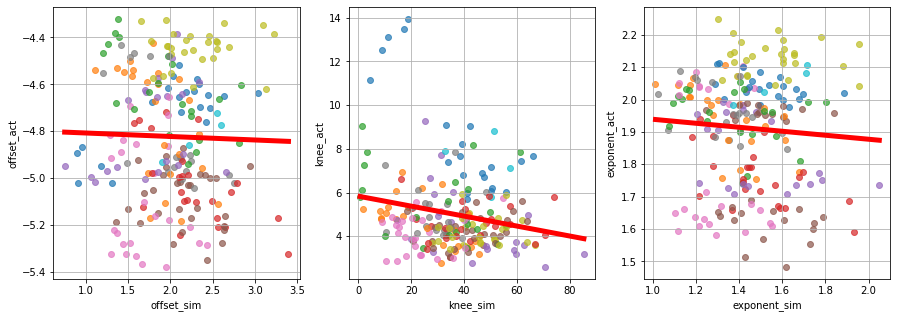

In [31]:
# plot summary graphic (average across channels)

chan_avg_df = full_df.groupby(['session', 'epoch_idx']).mean().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(chan_avg_df, f"{var}_sim", f"{var}_act", color_by="session", ax=axs[i])
    print(f"{var}: {res}")

In [124]:
# # plot summary graphic (average across channels) - plot each subject separately 

# chan_avg_df = full_df.groupby(['session', 'epoch_idx']).mean().reset_index()
# sessions = full_df['session'].unique()

# for session in sessions:
#     df_s = chan_avg_df[chan_avg_df['session'] == session]

#     fig, axs = plt.subplots(1, 3, figsize=(15,5))
#     for i, var in enumerate(['offset', 'knee', 'exponent']):
        
#         res = linplot(df_s, f"{var}_sim", f"{var}_act", color_by="session", ax=axs[i])
#         print(f"{var}: {res}")

In [32]:
# join with spike stats df

spike_df = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/{STIM_CODE}.csv')
vis_spike_df = spike_df[spike_df['brain_structure'] == 'VISp']
spike_lfp_df = chan_avg_df.merge(vis_spike_df, on=['session', 'epoch_idx'])

('mean_firing_rate', 'r_squared_sim'): LinregressResult(slope=0.0008720597906444078, intercept=0.933032217116288, rvalue=0.13830566729126884, pvalue=0.04229105961944519, stderr=0.00042687966453148503, intercept_stderr=0.002682749988288894)


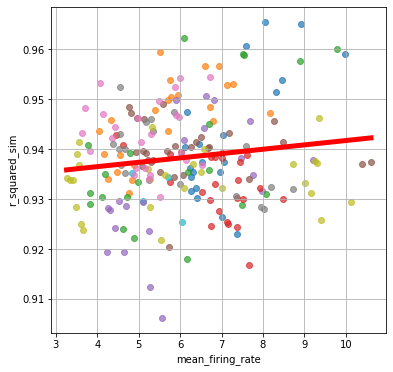

In [33]:
# quality analysis

fig, axs = plt.subplots(1, 1, figsize=(6,6))

for i, var in enumerate([('mean_firing_rate', 'r_squared_sim')]):
    
    res = linplot(spike_lfp_df, var[0], var[1], color_by="session", ax=axs)
    print(f"{var}: {res}")

('mean_firing_rate', 'offset_sim'): LinregressResult(slope=0.016935338699756133, intercept=1.9137523890293913, rvalue=0.05567461162259409, pvalue=0.415570393793669, stderr=0.020761354089491577, intercept_stderr=0.13047593284064032)
('spike_distance', 'exponent_sim'): LinregressResult(slope=1.9472703890168583, intercept=1.1586269662577462, rvalue=0.19355130352895794, pvalue=0.004301590585150207, stderr=0.6747333716478456, intercept_stderr=0.10035860110504213)


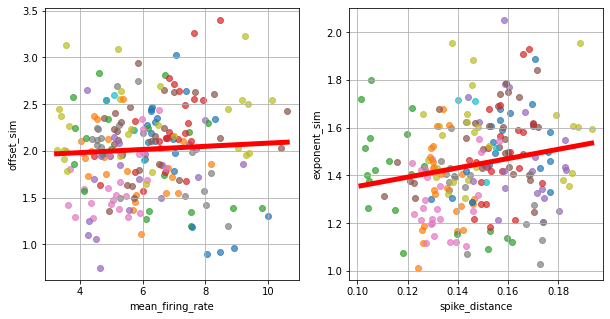

In [34]:
# hypothesis plots

fig, axs = plt.subplots(1, 2, figsize=(10,5))

for i, var in enumerate([('mean_firing_rate', 'offset_sim'), ('spike_distance', 'exponent_sim')]):
    
    res = linplot(spike_lfp_df, var[0], var[1], color_by="session", ax=axs[i])
    print(f"{var}: {res}")

Now we show results where each current is weighted by (V_rest - V_rev), the lfp is calculated as the sum of these weighted currents, and nans are not handled.

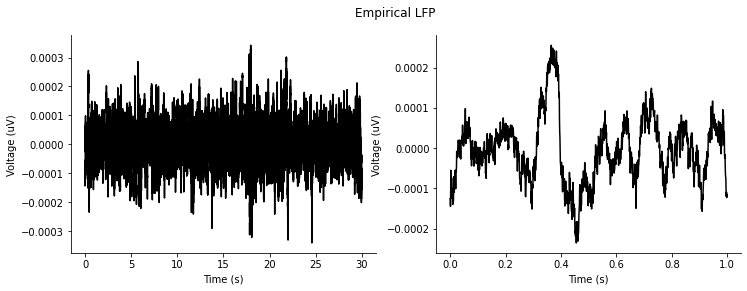

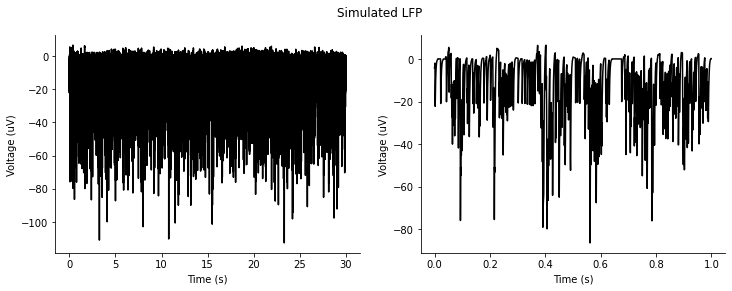

In [136]:
# load example block
session = 816200189
i_seg = 4
lfp_chan = 0

block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/block_{session}.mat").read_block()
seg = block.segments[i_seg]

lfp = np.array(seg.filter(name='lfp')[0])[:37500][:, lfp_chan]
sim_lfp = np.load(f"{PROJECT_PATH}/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/empirical_lfp/{session}.npy")[i_seg]

# plot
# plot empirical and simulates lfp
for signal, title in zip([lfp, sim_lfp], ['Empirical LFP', 'Simulated LFP']):
    plot_lfp(signal, FS, title)


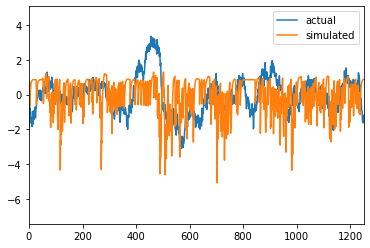

In [21]:
# plot examples with actual LFP side by side

plt.plot(zscore(lfp), label='actual')
plt.plot(zscore(sim_lfp), label='simulated')
plt.xlim([0,FS])
plt.legend();

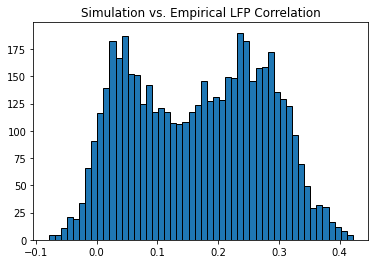

In [22]:
# plot correlation coefficient distribution
sim_lfp_df = pd.read_csv(f'D:/visual_encoding/data/lfp_data/sim/{STIM_CODE}/voltage_weighted/params.csv')

plt.hist(sim_lfp_df['sim_corr'], edgecolor='black', bins=50)
plt.title('Simulation vs. Empirical LFP Correlation');

offset: LinregressResult(slope=0.016915251021499298, intercept=-4.923351255341467, rvalue=0.00881005709939976, pvalue=0.5294155120724876, stderr=0.026894790105123367, intercept_stderr=0.1458049125827643)
knee: LinregressResult(slope=0.005955842230170293, intercept=5.004480946571904, rvalue=0.029452621851096743, pvalue=0.06157927603469121, stderr=0.003185223864777406, intercept_stderr=0.12548853593997464)
exponent: LinregressResult(slope=-0.06310444635399635, intercept=1.9911156011490103, rvalue=-0.03752109942571318, pvalue=0.007377549906560722, stderr=0.023543106832283736, intercept_stderr=0.03191282499565758)


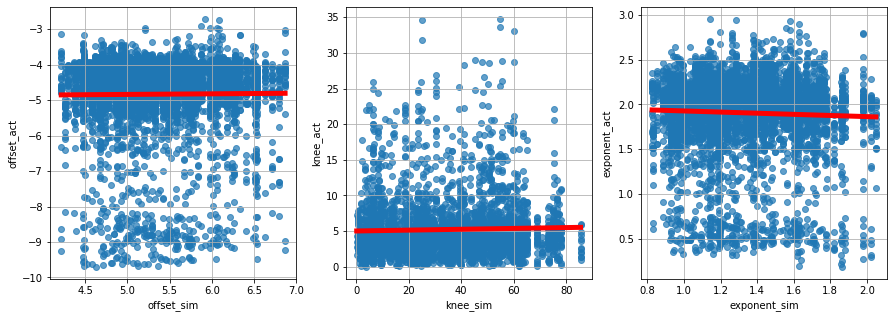

In [23]:
# plot specparams

full_df = sim_lfp_df.merge(param_df, on=['session', 'epoch_idx', 'chan_idx'], suffixes=('_sim', '_act'))

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(full_df, f"{var}_sim", f"{var}_act", ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=0.016915251021499298, intercept=-4.923351255341467, rvalue=0.00881005709939976, pvalue=0.5294155120724876, stderr=0.026894790105123367, intercept_stderr=0.1458049125827643)
knee: LinregressResult(slope=0.005955842230170293, intercept=5.004480946571904, rvalue=0.029452621851096743, pvalue=0.06157927603469121, stderr=0.003185223864777406, intercept_stderr=0.12548853593997464)
exponent: LinregressResult(slope=-0.06310444635399635, intercept=1.9911156011490103, rvalue=-0.03752109942571318, pvalue=0.007377549906560722, stderr=0.023543106832283736, intercept_stderr=0.03191282499565758)


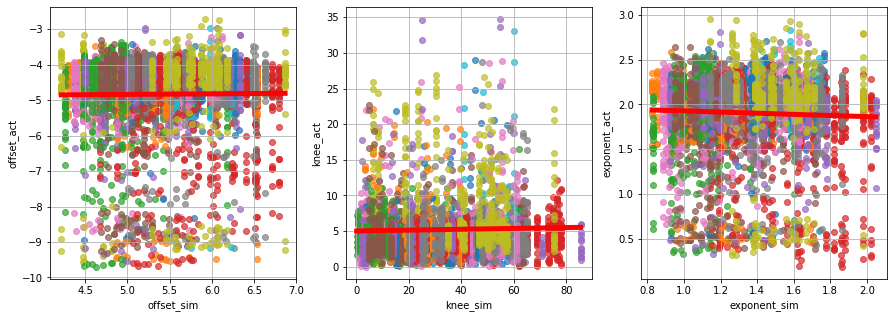

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(full_df, f"{var}_sim", f"{var}_act", color_by="session" ,ax=axs[i])
    print(f"{var}: {res}")

offset: LinregressResult(slope=0.024703781130845353, intercept=-4.95498978715353, rvalue=0.052693824604923764, pvalue=0.44101539971338066, stderr=0.03200317339633987, intercept_stderr=0.17335241048011304)
knee: LinregressResult(slope=0.0060269799776385465, intercept=4.817745186279295, rvalue=0.06611170104926248, pvalue=0.3346486606982897, stderr=0.006232760474978612, intercept_stderr=0.24276048997311248)
exponent: LinregressResult(slope=-0.05751108010554655, intercept=1.9883007998979272, rvalue=-0.09007377575404694, pvalue=0.18723274375028318, stderr=0.04346876545298928, intercept_stderr=0.05896318974554421)


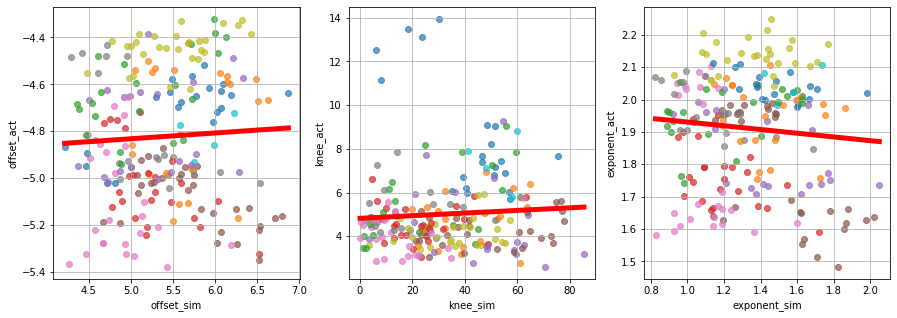

In [25]:
# plot summary graphic (average across channels)

chan_avg_df = full_df.groupby(['session', 'epoch_idx']).mean().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, var in enumerate(['offset', 'knee', 'exponent']):
    
    res = linplot(chan_avg_df, f"{var}_sim", f"{var}_act", color_by="session", ax=axs[i])
    print(f"{var}: {res}")

Let's take a look at correlations between spiking statistics and our simulated LFP.

In [26]:
# join with spike stats df

spike_df = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/{STIM_CODE}.csv')
vis_spike_df = spike_df[spike_df['brain_structure'] == 'VISp']
spike_lfp_df = chan_avg_df.merge(vis_spike_df, on=['session', 'epoch_idx'])

('mean_firing_rate', 'r_squared_sim'): LinregressResult(slope=2.95065936125238e-05, intercept=0.93227003377769, rvalue=0.0051660547487779995, pvalue=0.93982872402813, stderr=0.0003904337830977674, intercept_stderr=0.0024537037344768368)


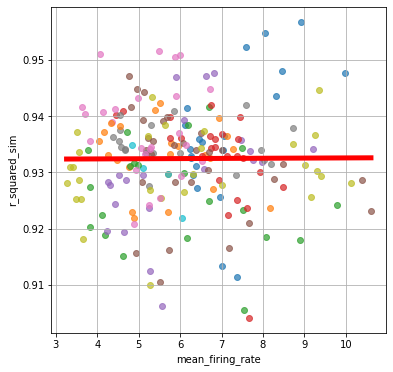

In [27]:
# quality analysis

fig, axs = plt.subplots(1, 1, figsize=(6,6))

for i, var in enumerate([('mean_firing_rate', 'r_squared_sim')]):
    
    res = linplot(spike_lfp_df, var[0], var[1], color_by="session", ax=axs)
    print(f"{var}: {res}")

('mean_firing_rate', 'offset_sim'): LinregressResult(slope=0.09061691977902042, intercept=4.83243020405162, rvalue=0.23775510335355013, pvalue=0.0004240049306631745, stderr=0.02530679731562479, intercept_stderr=0.15904203419161556)
('spike_distance', 'exponent_sim'): LinregressResult(slope=3.397955873459435, intercept=0.8283103434028066, rvalue=0.2457871792918759, pvalue=0.0002648343564414676, stderr=0.9160527997210202, intercept_stderr=0.1362520091363447)


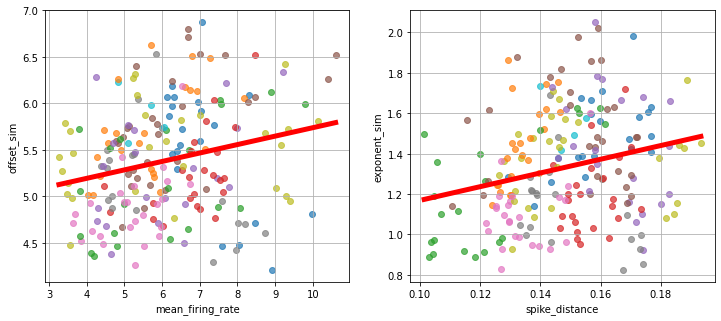

In [28]:
# plot sim offset vs. firing rate

fig, axs = plt.subplots(1, 2, figsize=(12,5))

for i, var in enumerate([('mean_firing_rate', 'offset_sim'), ('spike_distance', 'exponent_sim')]):
    
    res = linplot(spike_lfp_df, var[0], var[1], color_by="session", ax=axs[i])
    print(f"{var}: {res}")